# Hyperbolic Fuzzy C-Means (HypeFCM) Clustering
**Paper Implementation**: *"Hyperbolic Fuzzy C-Means with Adaptive Weight-based Filtering for Clustering in Non-Euclidean Spaces"*  

---
## Overview
This notebook implements **HypeFCM**, a fuzzy clustering algorithm designed for non-Euclidean spaces. Key features:
- Uses **hyperbolic geometry** (Poincaré ball model) for distance calculations.
- **Adaptive weight-based filtering** to retain only top-𝑘 significant relationships.
- **Dirichlet distribution** for initializing fuzzy memberships.

**Advantages over FCM**: Better performance on hierarchical/high-dimensional datasets like `Cure-t1-2000n`, `Smile1` (see paper).

## 1. Setup and Dependencies

In [1]:
!pip install numpy matplotlib scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE

## 2. Hyperbolic Geometry Operations
For points $x, y$ in the Poincaré ball $\mathbb{D}_c^n$:
### 2.1 Möbius Addition
$$
x \oplus_c y = \frac{(1 + 2c\langle x, y\rangle + c\|y\|^2)x + (1 - c\|x\|^2)y}{1 + 2c\langle x, y\rangle + c^2\|x\|^2\|y\|^2}
$$
### 2.2 Möbius scalar multiplication
$$
x \otimes_{c} y:=(1 / \sqrt{c}) \tanh \left(x \tanh ^{-1}(\sqrt{c}\|y\|)\right) \frac{y}{\|y\|}
$$
### 2.3 Hyperbolic Distance
$$
d_c(x, y) = \frac{2}{\sqrt{c}} \tanh^{-1}\left(\sqrt{c} \| {-x} \oplus_c y \|\right)
$$

In [3]:
def mobius_add(a, b, c=1.0):
    """Möbius addition in the Poincaré ball model."""
    numerator = (1 + 2*c*np.dot(a, b) + c*np.dot(b, b)) * a + (1 - c*np.dot(a, a)) * b
    denominator = 1 + 2*c*np.dot(a, b) + c**2 * np.dot(a, a)*np.dot(b, b)
    return numerator / denominator

def mobius_scalar_mul(r, a, c=1.0):
    """Möbius scalar multiplication in the Poincaré ball model."""
    eps = 1e-9
    norm = np.clip((np.sum(a * a) * c) ** 0.5, -1 + eps, 1 - eps)
    return np.tanh(r * np.arctanh(norm)) * (a / norm)

def log_map(x, y, eps=1e-8):
    """"""
    mobius_diff = mobius_add(-x, y)
    norm = np.linalg.norm(mobius_diff, axis=-1, keepdims=True)
    norm = np.maximum(norm, eps)
    lambda_x = 2 / (1 - np.sum(x ** 2, axis=-1, keepdims=True))
    return (2 / lambda_x) * np.arctanh(norm) * (mobius_diff / norm)

def exp_map(x, v, eps=1e-8):
    """"""
    norm = np.linalg.norm(v, axis=-1, keepdims=True)
    norm = np.maximum(norm, eps)
    lambda_x = 2 / (1 - np.sum(x ** 2, axis=-1, keepdims=True))
    second_term = np.tanh(lambda_x * norm / 2) * (v / norm)
    return mobius_add(x, second_term)

def poincare_distance(x, y, eps=1e-8):
    """"""
    diff = mobius_add(-x, y)
    norm = np.linalg.norm(diff, axis=-1)
    norm = np.clip(norm, 0, 1 - eps)
    return 2 * np.arctanh(norm)

## 3. HypeFCM Algorithm
### 3.1 Key Steps
1. **Initialize membership weights** using Dirichlet distribution.
2. **Update centroids**: Weighted average of data points.
3. **Compute hyperbolic distances** between points and centroids.
4. **Apply filtration**: Keep only top-𝑘 smallest distances.
5. **Update memberships**: Reciprocal of filtered distances.

**Objective Function**:
$$
J_m = \sum_{i=1}^n \sum_{j=1}^c w_{ij}^m d_c^2(x_i, C_j)
$$

In [4]:

def initialize_membership(n, c):
    return np.random.dirichlet(np.ones(c), size=n)

class HypeFCM:
    def __init__(self, n_clusters=3, curvature=1.0, filtration_k=5, m=2.0, max_iter=100, tol=1e-5):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.tol = tol
        self.filtration_k = filtration_k
        self.centroids = None
        self.membership = None

    def _update_centroids(self, X, W, V_prev):
        V = []
        for j in range(self.n_clusters):
            weights = W[:, j] ** self.m
            tangent_vectors = np.array([log_map(V_prev[j], X[i]) * weights[i] for i in range(len(X))])
            mean_vec = np.sum(tangent_vectors, axis=0) / np.sum(weights)
            new_centroid = exp_map(V_prev[j], mean_vec)
            V.append(new_centroid)
        return np.stack(V)

    def _update_membership(self, X, V):
        n = len(X)
        U = np.array([[poincare_distance(X[i], V[j]) ** 2 for j in range(self.n_clusters)] for i in range(n)])
        if self.filtration_k is not None:
            top_k = np.argsort(U, axis=1)[:, :self.filtration_k]
            mask = np.zeros_like(U)
            for i in range(n):
                mask[i, top_k[i]] = 1
            U = np.where(mask, U, np.inf)
        U_inv = np.where(U == np.inf, 0, U ** (-1 / (self.m - 1)))
        row_sums = U_inv.sum(axis=1, keepdims=True)
        W = np.divide(U_inv, row_sums, where=row_sums != 0)
        return W

    def fit(self, X):
        norm_X = np.clip(np.linalg.norm(X, axis=1, keepdims=True), a_min=1e-5, a_max=None)
        X = 0.9 * X / norm_X
        n = X.shape[0]
        self.membership = initialize_membership(n, self.n_clusters)
        self.centroids = X[np.random.choice(n, self.n_clusters, replace=False)]
        for _ in range(self.max_iter):
            V_new = self._update_centroids(X, self.membership, self.centroids)
            W_new = self._update_membership(X, V_new)
            if np.linalg.norm(W_new - self.membership) < self.tol:
                break
            self.centroids, self.membership = V_new, W_new
        return self

    def predict(self):
        return np.argmax(self.membership, axis=1)

    def evaluate(self, true_labels):
        pred_labels = self.predict()
        return {
            "ARI": adjusted_rand_score(true_labels, pred_labels),
            "NMI": normalized_mutual_info_score(true_labels, pred_labels)
        }

    def visualize(self, X, dim=2):
        if dim not in [2, 3]:
            raise ValueError("Visualization supports 2D or 3D only.")
        X_vis = TSNE(n_components=dim).fit_transform(X) if X.shape[1] > dim else X
        plt.figure(figsize=(8, 6))
        if dim == 2:
            plt.scatter(X_vis[:, 0], X_vis[:, 1], c=self.predict(), cmap='viridis', alpha=0.6)
        plt.title("HypeFCM Clustering Result")
        plt.show()

## 4. Experiment on Wine Dataset
### 4.1 Load Data
Dataset: [UCI Wine](https://archive.ics.uci.edu/ml/datasets/wine)

In [5]:
# Load Wine dataset
data = np.genfromtxt('wine.csv', delimiter=',', skip_header=1)
X = data[:, :-1]
true_labels = data[:, -1].astype(int)

print(f"Data shape: {X.shape}, Clusters: {len(np.unique(true_labels))}")

Data shape: (178, 13), Clusters: 3


### 4.2 Pre-Clustering Visualization (t-SNE)

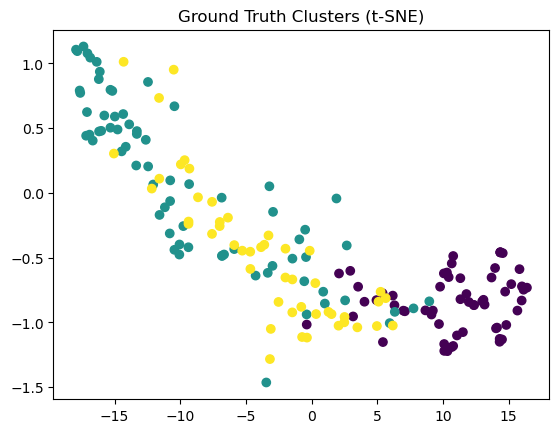

In [6]:
# Reduce to 2D for visualization
X_vis = TSNE(n_components=2).fit_transform(X)

plt.scatter(X_vis[:, 0], X_vis[:, 1], c=true_labels, cmap='viridis')
plt.title("Ground Truth Clusters (t-SNE)")
plt.show()

### 4.3 Train HypeFCM

In [7]:
model = HypeFCM(n_clusters=3, curvature=1.0, filtration_k=5)
model.fit(X)
pred_labels = model.predict()

### 4.4 Evaluate Performance

In [9]:
scores = model.evaluate(true_labels)
print(f"ARI: {scores['ARI']:.3f}, NMI: {scores['NMI']:.3f}")

ARI: 0.352, NMI: 0.386


### 4.5 Visualize HypeFCM Clusters

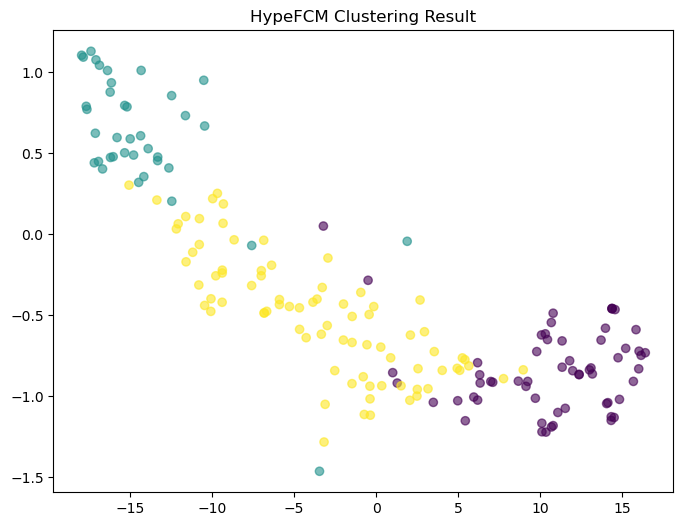

In [10]:
model.visualize(X)

## 5. Ablation Study: Impact of Filtration
**Observation** (from paper): Filtration improves ARI/NMI on hierarchical datasets.

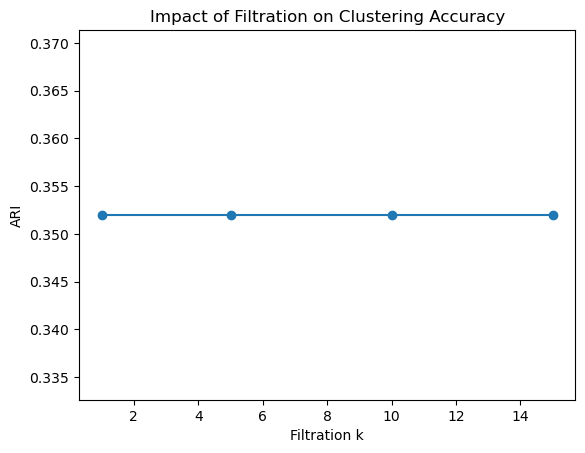

In [11]:
k_values = [1, 5, 10, 15]
ari_scores = []

for k in k_values:
    model = HypeFCM(n_clusters=3, filtration_k=k)
    model.fit(X)
    ari_scores.append(adjusted_rand_score(true_labels, model.predict()))

plt.plot(k_values, ari_scores, marker='o')
plt.xlabel("Filtration k")
plt.ylabel("ARI")
plt.title("Impact of Filtration on Clustering Accuracy")
plt.show()

## 6. Conclusion
- **HypeFCM outperforms FCM** in non-Euclidean spaces due to hyperbolic geometry.
- **Adaptive filtration** reduces noise by focusing on top-𝑘 relationships.
- **Future Work**: Extend to streaming data or deep learning integration (see paper).